In [1]:
from soma import aims 
import pandas as pd 
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import find_peaks

## NOISE REMOVAL 
#from skimage.filters.rank import median 
from scipy.ndimage import median_filter, gaussian_filter, generic_filter
from skimage.morphology import disk, ball, cube
from scipy.stats import trim_mean

In [2]:
def alpha_trim(y):
    
    inp = y.copy()
    inp.sort()
    
    middleIdx = int(len(inp)/2)
    
    return np.mean(inp[middleIdx-1:middleIdx+2])

def alpha_trim_only_outside_range(y, first_peak):
    inp = y.copy()
    middleIdx = int(len(inp)/2)
    
    if (0< inp[middleIdx] < first_peak) or (inp[middleIdx] > 0.95):
        inp.sort()
        inp = inp[(inp >= first_peak) & (inp < 0.95)]
        
        if len(inp) <= 1:
            return np.nan
    
        elif 1 < len(inp) < 3:
            return np.mean(inp)
        
        else: 
            idx = int(len(inp)/2)
            return np.mean(inp[idx-1:idx+2])
            #return np.mean(inp)
    else: 
        return inp[middleIdx]
    
def calculate_corrected_number(y, first_peak):
    inp = y.copy()
    middleIdx = int(len(inp)/2)
    
    if (0 < inp[middleIdx] < first_peak) or (inp[middleIdx] > 0.95):
        inp.sort()
        inp = inp[(inp >= first_peak) & (inp < 0.95)]
        
        if len(inp) <= 1:
            return 2000

        elif 1 < len(inp) < 3:
            return 1000
        
        else: 
            idx = int(len(inp)/2)
            return 1000
            #return np.mean(inp)
    else: 
        return inp[middleIdx]

### assesing the NODDI post-processing

In [3]:
controls = pd.read_csv('../../DerivedData/control_group_list.csv', header=None)

In [4]:
def denoise_NDI(NDI_image, arg):

    new_NDI = NDI_image.copy()
    for i in range(len(arg[0])):
        idx = (arg[0][i], arg[1][i], arg[2][i])
        #print(im_NDI[idx])
        if im_NDI[idx] > 0:
        
    
            cube = im_NDI[idx[0]-1:idx[0]+2,idx[1]-1:idx[1]+2,idx[2]-1:idx[2]+2 ]
            inp = cube.ravel()
            middleIdx = int(len(inp)/2)
            inp.sort()
        
            new_NDI[idx] = np.mean(inp[middleIdx-1:middleIdx+2])
            
            #new_NDI[idx] = np.mean(inp[1:-1])
    
            #print(np.mean(inp[middleIdx-1:middleIdx+2]))
            #print(np.mean(inp[1:-1]))
            #print(inp)
    
        else: 
            new_NDI[idx] = im_NDI[idx]
            #print(im_NDI[idx])
        
    return new_NDI

CC00939XX24
CC00184XX12
CC00616XX14
('CC00616XX14', 0.28995592869964815)


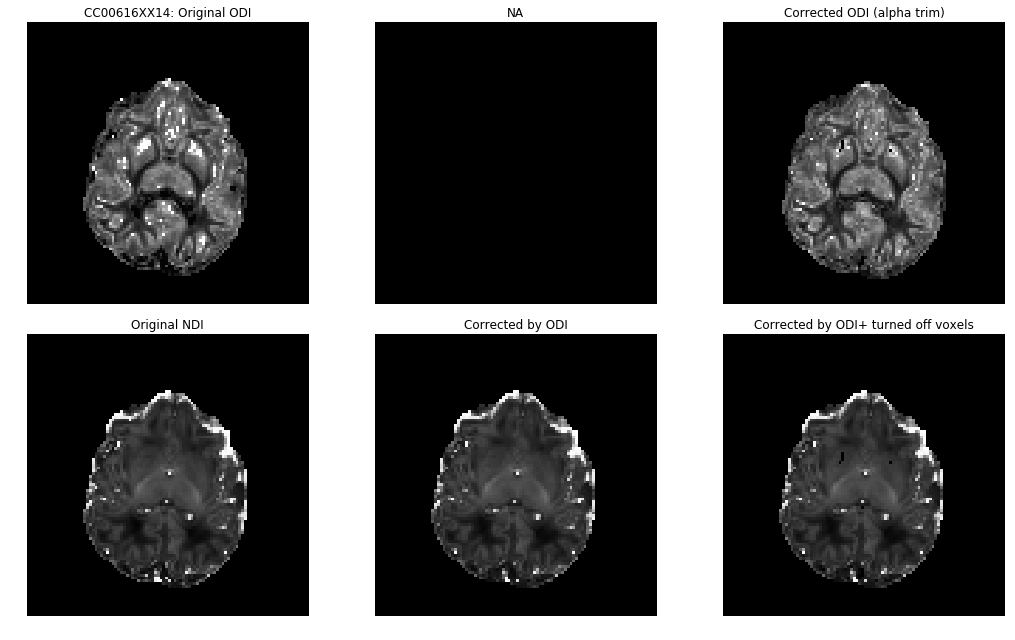

CC00801XX09
CC00205XX07
CC00731XX14
CC00550XX06
CC00589XX21
CC00100XX01
CC00852XX11
CC00427XX15
CC01042XX12
CC00247XX17
CC00566XX14
CC00586XX18
CC00498XX21
CC00362XX08
CC00549XX22
CC00071XX06
CC00675XX16
CC00716XX15
('CC00716XX15', 0.3071149539531104)


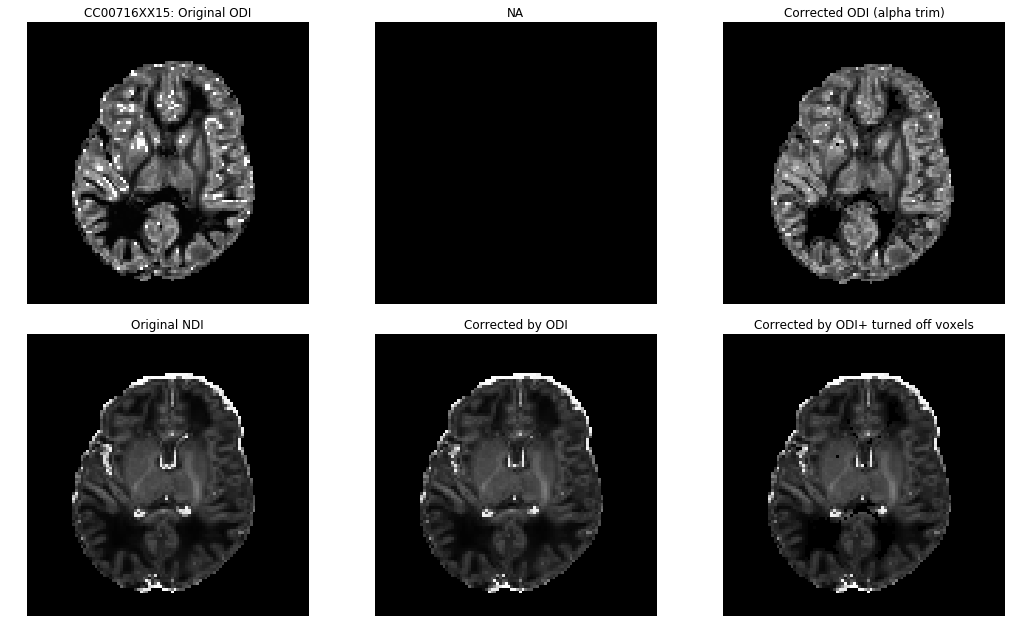

CC01198XX20
CC00111XX04
CC00584XX16
CC00150AN02
('CC00150AN02', 0.2621137866390001)


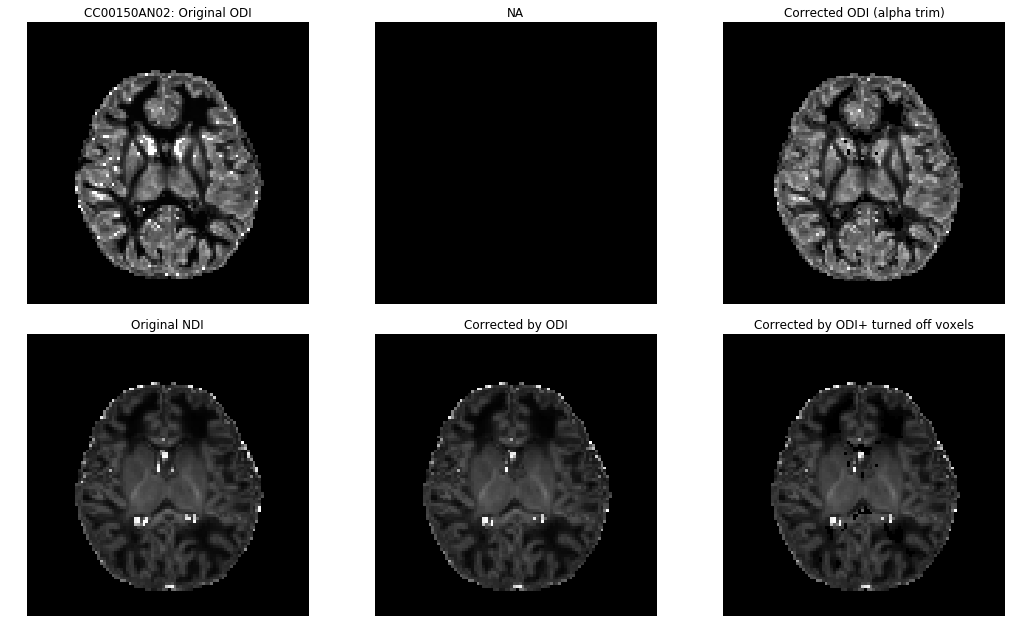

CC00383XX13
CC00477XX16
CC00865XX16
CC00364XX10
CC00174XX10
CC00540XX13
CC00424XX12
CC00353XX07
CC00500XX05
CC00122XX07
CC00663XX12
CC00667XX16
CC00527XX16
CC00537XX18
CC00713XX12
CC00314XX09
CC00740XX15
CC00082XX09
CC00425XX13
CC00653XX10
CC00485XX16
CC00096XX15
CC00219XX13
CC00502XX07
CC00765XX15
CC00594XX18
CC00798XX24
CC00067XX10
CC00508XX13
CC00265XX10
CC00270XX07
CC00402XX06
CC01014XX08
CC00822XX14
CC00475XX14
CC00516XX13
CC00577XX17
CC00593XX17
CC00091XX10
CC00409XX13
CC00469XX16
CC00178XX14
CC00149XX18
CC00497XX20


In [6]:
errors = []
errors_corrected_only = []
for i, row in controls.iterrows():

    print(row[0])
    iVol = aims.read('/neurospin/grip/external_databases/dHCP_CR_JD_2018/release3/dhcp_dmri_shard_pipeline/sub-{}/ses-{}/dwi/NODDI/OD.nii.gz'.format(row[0], row[1]))
    im = iVol.arraydata()[0]

    
    ### get range
    his, bin_edges = np.histogram(im.ravel(), bins=np.arange(0.01,1.01,0.01))
    peaks, _ = find_peaks(his*-1, distance=25)
    first_peak = round(bin_edges[peaks[0]],3)
    #print(first_peak)
    
    ### quantify found for correction 
    denoised = generic_filter(im, calculate_corrected_number, size=2, extra_arguments=(first_peak,))
    
    
    #print('Corrected voxels: {} ({}%)'.format(
    #                    len(denoised[denoised == 1000]),
    #                    len(denoised[denoised == 1000])*100/len(denoised.ravel())))
    #print('Set to NAN {} ({}%)'.format(
    #                    len(denoised[denoised == 2000]),
    #                    len(denoised[denoised == 2000])*100/len(denoised.ravel())))
    
    # ODI
    ### Correct ODI
    denoised_ODI = generic_filter(im, alpha_trim_only_outside_range, size=2, extra_arguments=(first_peak,))
    denoised_ODI[ np.isnan(denoised_ODI)] = 0
    
    # NDI
    ### Set 'turned-off' voxels found in ODI to 0 in NDI file as well
    iVol = aims.read('/neurospin/grip/external_databases/dHCP_CR_JD_2018/release3/dhcp_dmri_shard_pipeline/sub-{}/ses-{}/dwi/NODDI/mean_fintra.nii.gz'.format(row[0], row[1]))
    im_NDI = iVol.arraydata()[0]
    
    #denoised_NDI = im_NDI.copy()
    #denoised_NDI[np.where(denoised == 2000)] = 0
    
    arg = np.where(denoised == 1000)
    denoised_NDI = denoise_NDI(NDI_image = im_NDI, arg = arg)
    
    denoised_NDI_turned_off = denoised_NDI.copy()
    denoised_NDI_turned_off[np.where(denoised == 2000)] = 0
    
    np.seterr(invalid='ignore')
    mean_error = np.nanmean((denoised_NDI[np.where(im_NDI != 0 )] - im_NDI[np.where(im_NDI != 0 )])/im_NDI[np.where(im_NDI != 0 )])
    errors.append(mean_error)
    
    
    ### do both denoised == 1000 and original != 0
    to_compare = np.where(np.logical_and( (denoised == 1000), (im_NDI != 0)))
    mean_error_corrected_only = np.nanmean((denoised_NDI[to_compare] - im_NDI[to_compare])/im_NDI[to_compare])
    errors_corrected_only.append(mean_error_corrected_only)
    
    if mean_error_corrected_only > 0.25:
        print(row[0], mean_error_corrected_only)
        
        
        # display results
        slc=28

        fig, axes = plt.subplots(2, 3, figsize=(15, 9), sharex=True, sharey=True)
        ax = axes.ravel()

        ax[0].imshow(im[slc,:,:], cmap=plt.cm.gray)
        ax[0].axis('off')
        ax[0].set_title('{}: Original ODI'.format(row[0]))

        ax[1].imshow(np.zeros_like(im[slc,:,:]), cmap=plt.cm.gray)
        ax[1].axis('off')
        ax[1].set_title('NA')

        ax[2].imshow(denoised_ODI[slc,:,:], cmap=plt.cm.gray)
        ax[2].axis('off')
        ax[2].set_title('Corrected ODI (alpha trim)')


        ax[3].imshow(im_NDI[slc,:,:], cmap=plt.cm.gray)
        ax[3].axis('off')
        ax[3].set_title('Original NDI')

        ax[4].imshow(denoised_NDI[slc,:,:], cmap=plt.cm.gray)
        ax[4].axis('off')
        ax[4].set_title('Corrected by ODI')


        ax[5].imshow(denoised_NDI_turned_off[slc,:,:], cmap=plt.cm.gray)
        ax[5].axis('off')
        ax[5].set_title('Corrected by ODI+ turned off voxels')


        fig.tight_layout()

        plt.show()

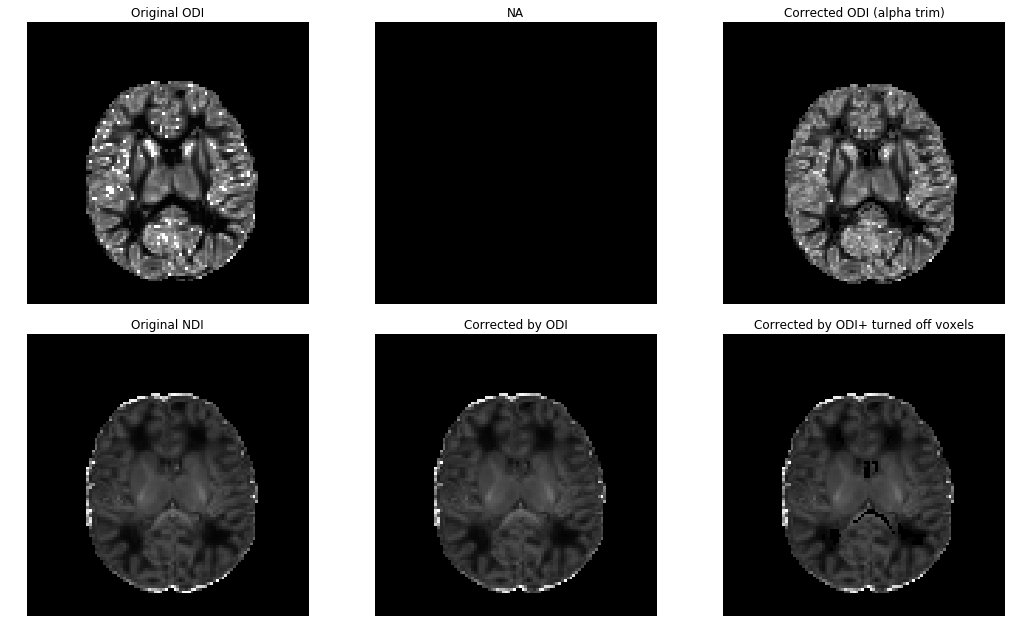

In [167]:
# display results
slc=28

fig, axes = plt.subplots(2, 3, figsize=(15, 9), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(im[slc,:,:], cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original ODI')

ax[1].imshow(np.zeros_like(im[slc,:,:]), cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('NA')

ax[2].imshow(denoised_ODI[slc,:,:], cmap=plt.cm.gray)
ax[2].axis('off')
ax[2].set_title('Corrected ODI (alpha trim)')


ax[3].imshow(im_NDI[slc,:,:], cmap=plt.cm.gray)
ax[3].axis('off')
ax[3].set_title('Original NDI')

ax[4].imshow(denoised_NDI[slc,:,:], cmap=plt.cm.gray)
ax[4].axis('off')
ax[4].set_title('Corrected by ODI')


ax[5].imshow(denoised_NDI_turned_off[slc,:,:], cmap=plt.cm.gray)
ax[5].axis('off')
ax[5].set_title('Corrected by ODI+ turned off voxels')


fig.tight_layout()

plt.show()

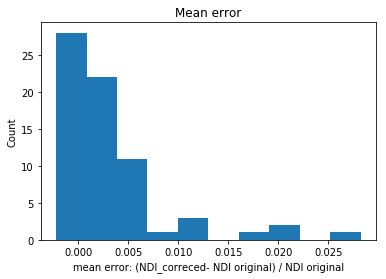

In [168]:
plt.hist(errors)
plt.title('Mean error')
plt.xlabel('mean error: (NDI_correced- NDI original) / NDI original')
plt.ylabel('Count')
plt.show()

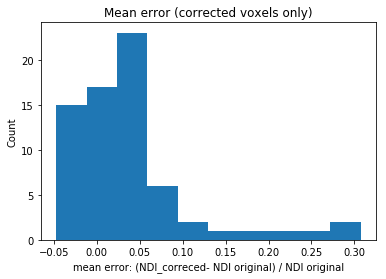

In [169]:
plt.hist(errors_corrected_only)
plt.title('Mean error (corrected voxels only)')
plt.xlabel('mean error: (NDI_correced- NDI original) / NDI original')
plt.ylabel('Count')
plt.show()

In [4]:
results = {}
results['threshold'] = []
results['corrected'] = []
results['set_to_zero'] = []
results['corrected_percent'] = []
results['set_to_zero_percent'] = []


tracts_nan = {}
tracts_corrected = {}

for i, row in controls.iterrows():

    print(row[0])
    iVol = aims.read('/neurospin/grip/external_databases/dHCP_CR_JD_2018/release3/dhcp_dmri_shard_pipeline/sub-{}/ses-{}/dwi/NODDI/OD.nii.gz'.format(row[0], row[1]))
    im = iVol.arraydata()[0]

    
    ### get range
    his, bin_edges = np.histogram(im.ravel(), bins=np.arange(0.01,1.01,0.01))
    peaks, _ = find_peaks(his*-1, distance=25)
    first_peak = round(bin_edges[peaks[0]],3)
    print(first_peak)
    
    ### quantify found for correction 
    denoised = generic_filter(im, calculate_corrected_number, size=2, extra_arguments=(first_peak,))
    
    
    #print('Corrected voxels: {} ({}%)'.format(
    #                    len(denoised[denoised == 1000]),
    #                    len(denoised[denoised == 1000])*100/len(denoised.ravel())))
    #print('Set to NAN {} ({}%)'.format(
    #                    len(denoised[denoised == 2000]),
    #                    len(denoised[denoised == 2000])*100/len(denoised.ravel())))
    
    results['threshold'].append(first_peak)
    results['corrected'].append(len(denoised[denoised == 1000]))
    results['corrected_percent'].append(len(denoised[denoised == 1000])*100/len(denoised.ravel()))
    results['set_to_zero'].append(len(denoised[denoised == 2000]))
    results['set_to_zero_percent'].append(len(denoised[denoised == 2000])*100/len(denoised.ravel()))
    
    
    ### Correct ODI
    denoised_ODI = generic_filter(im, alpha_trim_only_outside_range, size=2, extra_arguments=(first_peak,))
    denoised_ODI[ np.isnan(denoised_ODI)] = 0
    
    
    # NDI
    ### Set 'turned-off' voxels found in ODI to 0 in NDI file as well
    iVol = aims.read('/neurospin/grip/external_databases/dHCP_CR_JD_2018/release3/dhcp_dmri_shard_pipeline/sub-{}/ses-{}/dwi/NODDI/mean_fintra.nii.gz'.format(row[0], row[1]))
    im_NDI = iVol.arraydata()[0]
    
    denoised_NDI = im_NDI.copy()
    denoised_NDI[np.where(denoised == 2000)] = 0
    
    
    ### assessing the effect on tractography
    
    iDir = '/neurospin/grip/external_databases/dHCP_CR_JD_2018/release3/dhcp_dmri_shard_pipeline/sub-{}/ses-{}/dwi/probtrakX_results'.format(
                    row[0], row[1])
    
    folders = [folder for folder in os.listdir(iDir) if 'ROIbyROI' in folder]
    for folder in folders:
        label = folder.split('2x2_')[-1]
        label = label.split('Mask')
        label = label[0] + label[1] 
        label = label.replace('sh', '')
    
        
        iVol = aims.read(os.path.join(iDir, folder, 'fdt_paths.nii.gz'))
        im = iVol.arraydata()[0]
        
        #print(len(im[im!= 0].ravel()))
        
        tract = denoised[np.where(im!= 0)].ravel()
        
        #print('Percentage affected for track {}: {}%'.format(label, len(tract[tract == 2000])*100/len(tract)))
        
        if label in tracts_nan.keys():
            tracts_nan[label].append(len(tract[tract == 2000])*100/len(tract))
        else:
            tracts_nan[label] = [len(tract[tract == 2000])*100/len(tract)]
            
        if label in tracts_corrected.keys():
            tracts_corrected[label].append(len(tract[tract == 1000])*100/len(tract))
        else:
            tracts_corrected[label] = [len(tract[tract == 1000])*100/len(tract)]

        #if label in thresholds_control.keys():
        #    thresholds_control[label].append(np.round(np.max(im.ravel())*0.05,2))
        #else:
        #    thresholds_control[label] = [np.round(np.max(im.ravel())*0.05,2)]
    
    """
    # display results 
    # images
    slc=28

    fig, axes = plt.subplots(1, 4, figsize=(25, 9), sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(im[slc,:,:], cmap=plt.cm.gray)
    ax[0].axis('off')
    ax[0].set_title('Original ODI')
    
    
    ax[1].imshow(denoised_ODI[slc,:,:], cmap=plt.cm.gray)
    ax[1].axis('off')
    ax[1].set_title('Ranged trim ODI')


    ax[2].imshow(im_NDI[slc,:,:], cmap=plt.cm.gray)
    ax[2].axis('off')
    ax[2].set_title('Original NDI')

    ax[3].imshow(denoised_NDI[slc,:,:], cmap=plt.cm.gray)
    ax[3].axis('off')
    ax[3].set_title('Cleaned NDI')

    fig.tight_layout()
    plt.show() 
    
    ## histograms 
    fig, axes = plt.subplots(1, 4, figsize=(25, 9), sharex=True, sharey=True)
    axes[0].hist(im.ravel(), bins=np.arange(0.01,1.01,0.01))
    axes[0].plot(bin_edges[peaks], peaks, 'x')
    
    axes[1].hist(denoised_ODI.ravel(), bins=np.arange(0.01,1.01,0.01))
    axes[2].hist(im_NDI.ravel(), bins=np.arange(0.01,1.01,0.01))
    axes[3].hist(denoised_NDI.ravel(), bins=np.arange(0.01,1.01,0.01))
    
    plt.show()"""

CC00939XX24
0.05


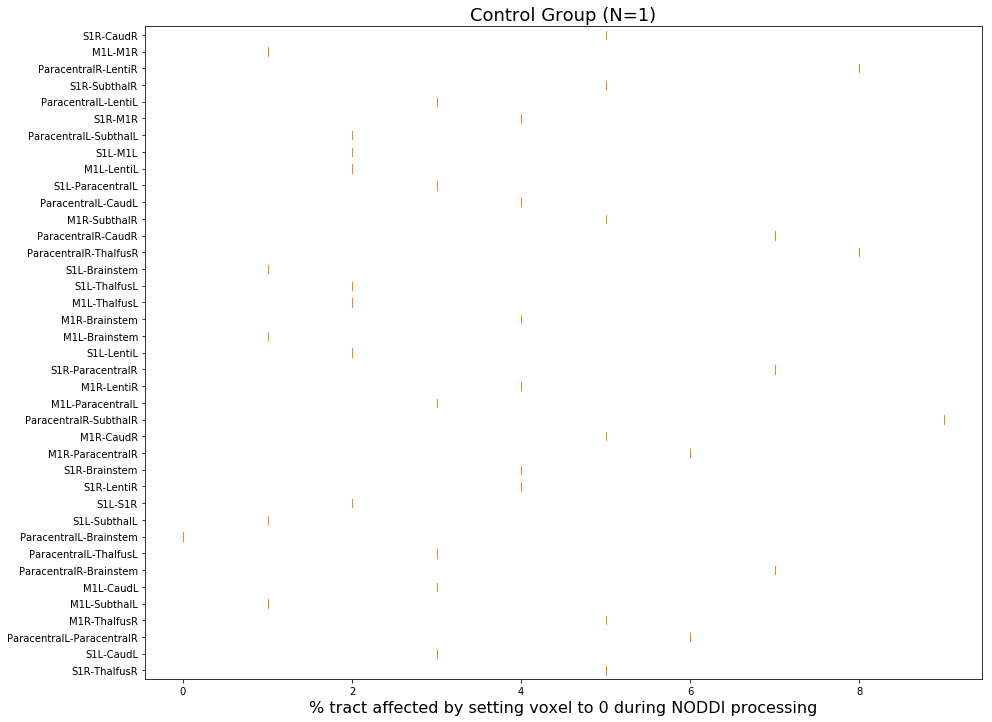

In [5]:
plt.figure(figsize=(15,12))
plt.boxplot(tracts_nan.values(), labels=tracts_nan.keys(), vert=False )
plt.title('Control Group (N={})'.format(len(tracts_nan['M1L-Brainstem'])), fontsize=18)
plt.xlabel('% tract affected by setting voxel to 0 during NODDI processing', fontsize=16)
plt.show()

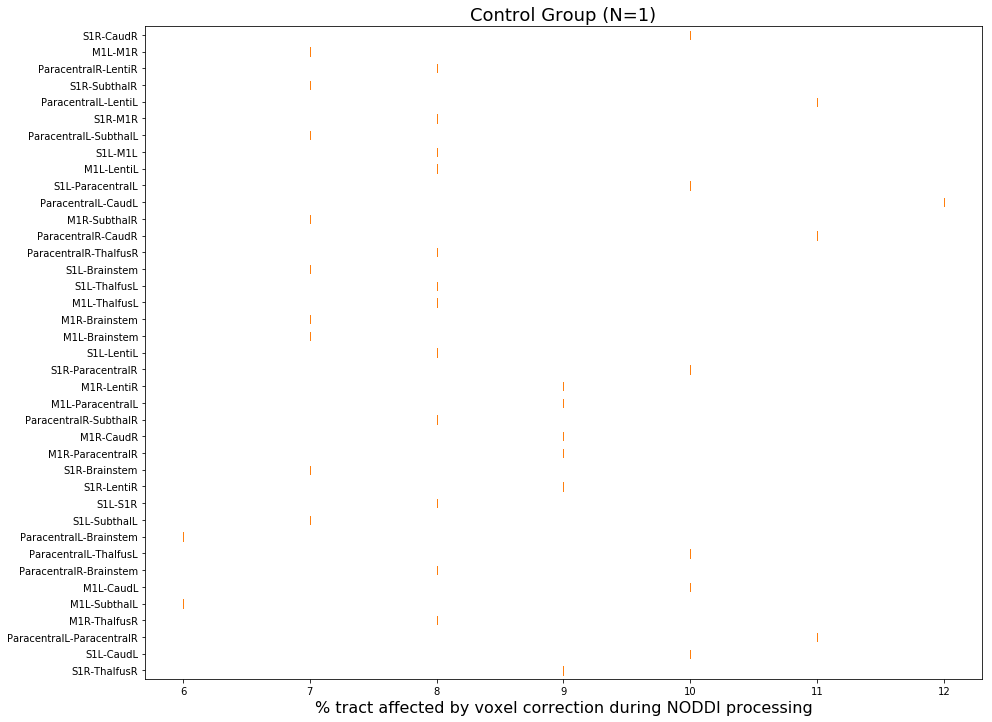

In [6]:
plt.figure(figsize=(15,12))
plt.boxplot(tracts_corrected.values(), labels=tracts_corrected.keys(), vert=False )
plt.title('Control Group (N={})'.format(len(tracts_corrected['M1L-Brainstem'])), fontsize=18)
plt.xlabel('% tract affected by voxel correction during NODDI processing', fontsize=16)
plt.show()

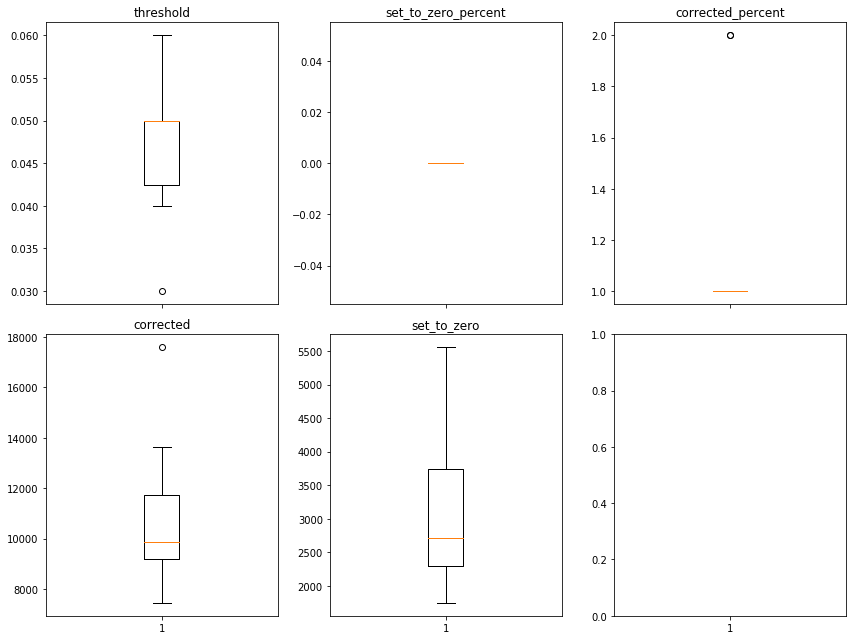

In [68]:
fig, axes = plt.subplots(2, 3, figsize=(12, 9), sharex=True, sharey=False)
ax = axes.ravel()

for i, key in enumerate(results.keys()):
    
    ax[i].boxplot(results[key], vert=True )
    ax[i].set_title(key)
    
plt.tight_layout()
plt.show()

## Setting up the cleaning 

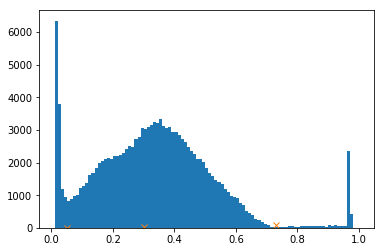

In [30]:
his, bin_edges = np.histogram(im.ravel(), bins=np.arange(0.01,1.01,0.01))
peaks, _ = find_peaks(his*-1, distance=25)
first_peak = round(bin_edges[peaks[0]],3)
plt.hist(im.ravel(), bins=np.arange(0.01,1.01,0.01))
plt.plot(bin_edges[peaks], peaks, 'x')
plt.show()

ODI 

In [2]:
## test subject 
subj_id = 'CC00111XX04'
ses_id = 37002

vol = aims.read('/neurospin/grip/external_databases/dHCP_CR_JD_2018/release3/dhcp_dmri_shard_pipeline/sub-{}/ses-{}/dwi/NODDI/OD.nii.gz'.format(subj_id, ses_id))
im = vol.arraydata()[0]
print(np.shape(im))

(64, 100, 100)


In [113]:
his, bin_edges = np.histogram(im.ravel(), bins=np.arange(0.01,1.01,0.01))
peaks, _ = find_peaks(his*-1, distance=25)
first_peak = round(bin_edges[peaks[0]],3)

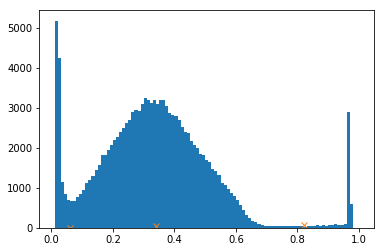

In [110]:
plt.hist(im.ravel(), bins=np.arange(0.01,1.01,0.01))
plt.plot(bin_edges[peaks], peaks, 'x')
plt.show()

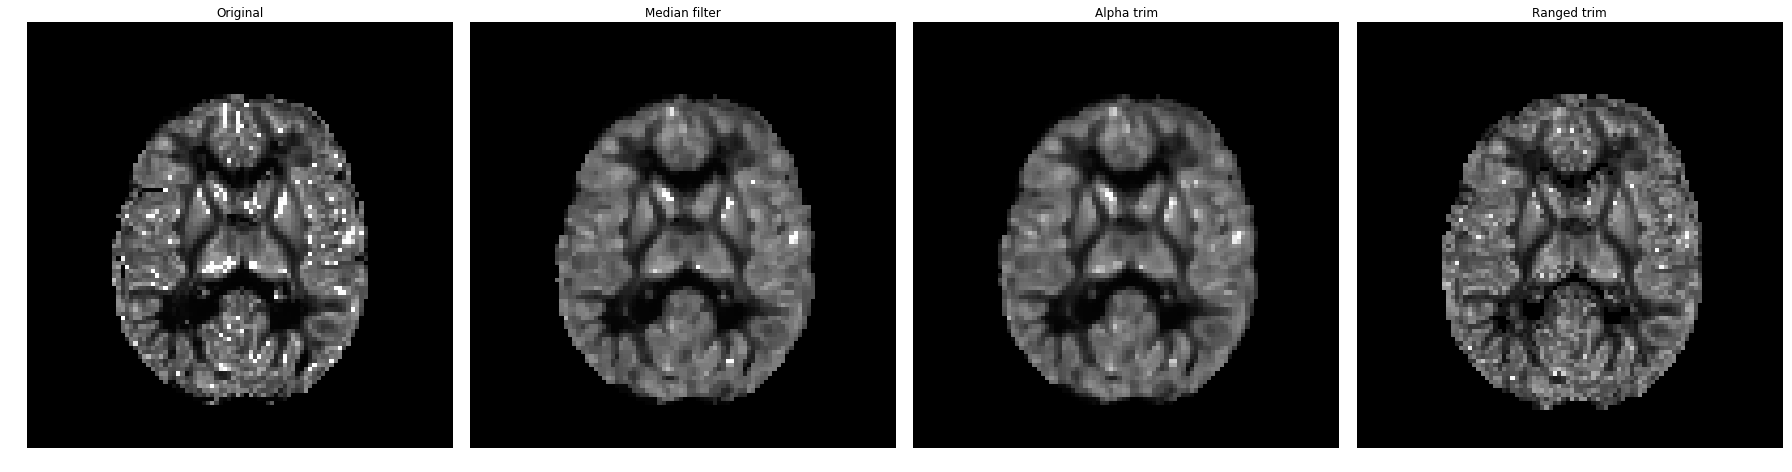

In [121]:
denoised_median = median_filter(im, size=2 )

denoised_alpha = generic_filter(im, alpha_trim, size=2)
denoised_alpha[ np.isnan(denoised_alpha)] = 0

### get range
his, bin_edges = np.histogram(im.ravel(), bins=np.arange(0.01,1.01,0.01))
peaks, _ = find_peaks(his*-1, distance=25)
first_peak = round(bin_edges[peaks[0]],3)

denoised_2 = generic_filter(im, alpha_trim_only_outside_range, size=2, extra_arguments=(first_peak,))
denoised_2[ np.isnan(denoised_2)] = 0

# display results
slc=28

fig, axes = plt.subplots(1, 4, figsize=(25, 9), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(im[slc,:,:], cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(denoised_median[slc,:,:], cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Median filter')


ax[2].imshow(denoised_alpha[slc,:,:], cmap=plt.cm.gray)
ax[2].axis('off')
ax[2].set_title('Alpha trim')

ax[3].imshow(denoised_2[slc,:,:], cmap=plt.cm.gray)
ax[3].axis('off')
ax[3].set_title('Ranged trim')



fig.tight_layout()

plt.show()

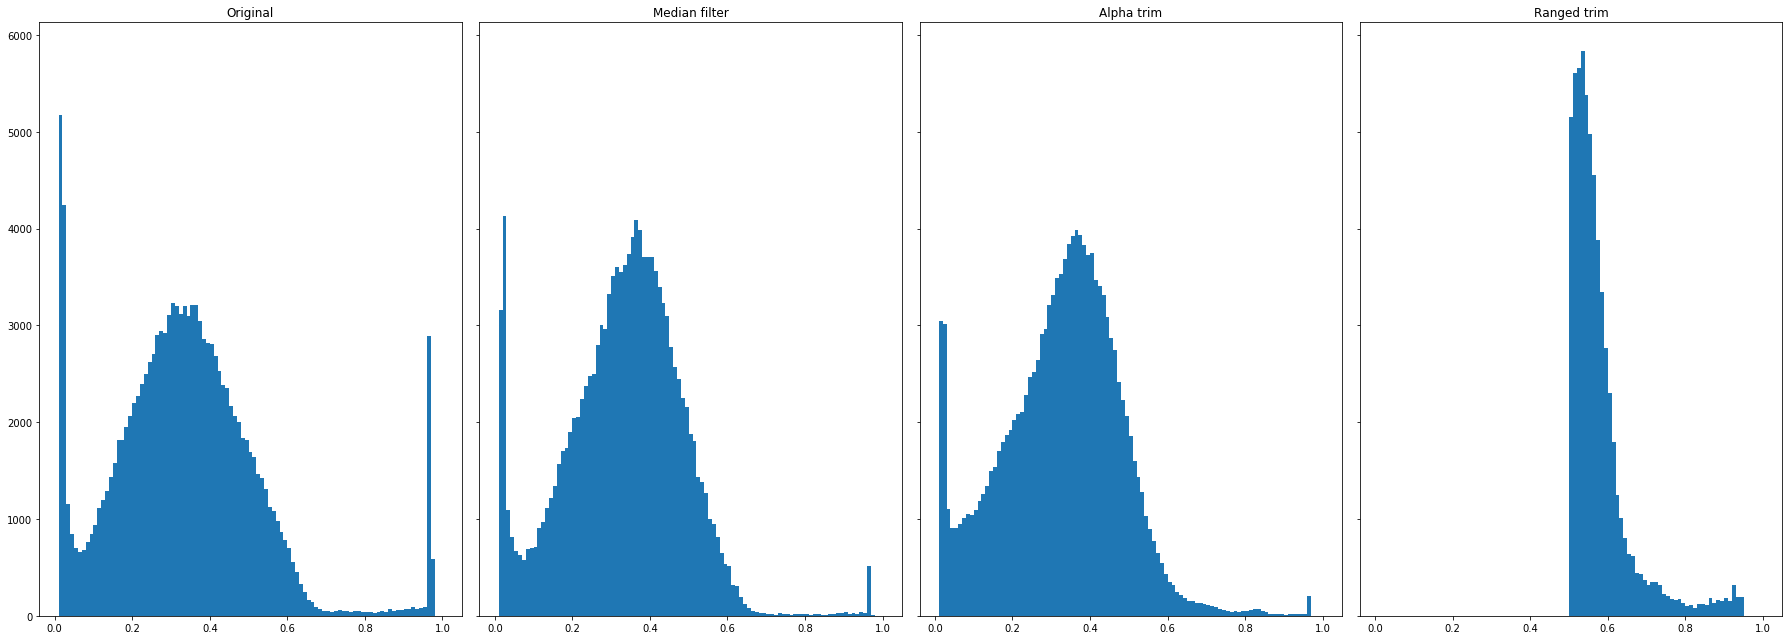

In [120]:
fig, axes = plt.subplots(1, 4, figsize=(25, 9), sharex=True, sharey=True)
bins=np.arange(0.01,1.01,0.01)
ax = axes.ravel()
ax[0].hist(im.ravel(), bins=bins)
#ax[0].axis('off')
ax[0].set_title('Original')

ax[1].hist(denoised_median.ravel(), bins=bins)
#ax[1].axis('off')
ax[1].set_title('Median filter')


ax[2].hist(denoised_alpha.ravel(), bins=bins)
#ax[2].axis('off')
ax[2].set_title('Alpha trim')

ax[3].hist(denoised_2.ravel(), bins=bins)
#ax[3].axis('off')
ax[3].set_title('Ranged trim')



fig.tight_layout()

plt.show()

NDI <br>
maybe does not require corrections. 

In [125]:
## test subject 
subj_id = 'CC00178XX14'
ses_id = 58600

vol = aims.read('/neurospin/grip/external_databases/dHCP_CR_JD_2018/release3/dhcp_dmri_shard_pipeline/sub-{}/ses-{}/dwi/NODDI/mean_fintra.nii.gz'.format(subj_id, ses_id))
im = vol.arraydata()[0]
print(np.shape(im))

(64, 100, 100)


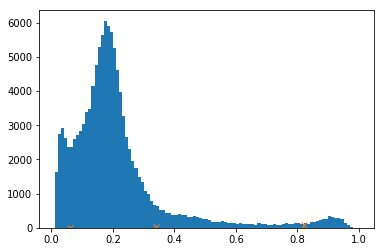

In [126]:
plt.hist(im.ravel(), bins=np.arange(0.01,1.01,0.01))
plt.plot(bin_edges[peaks], peaks, 'x')
plt.show()

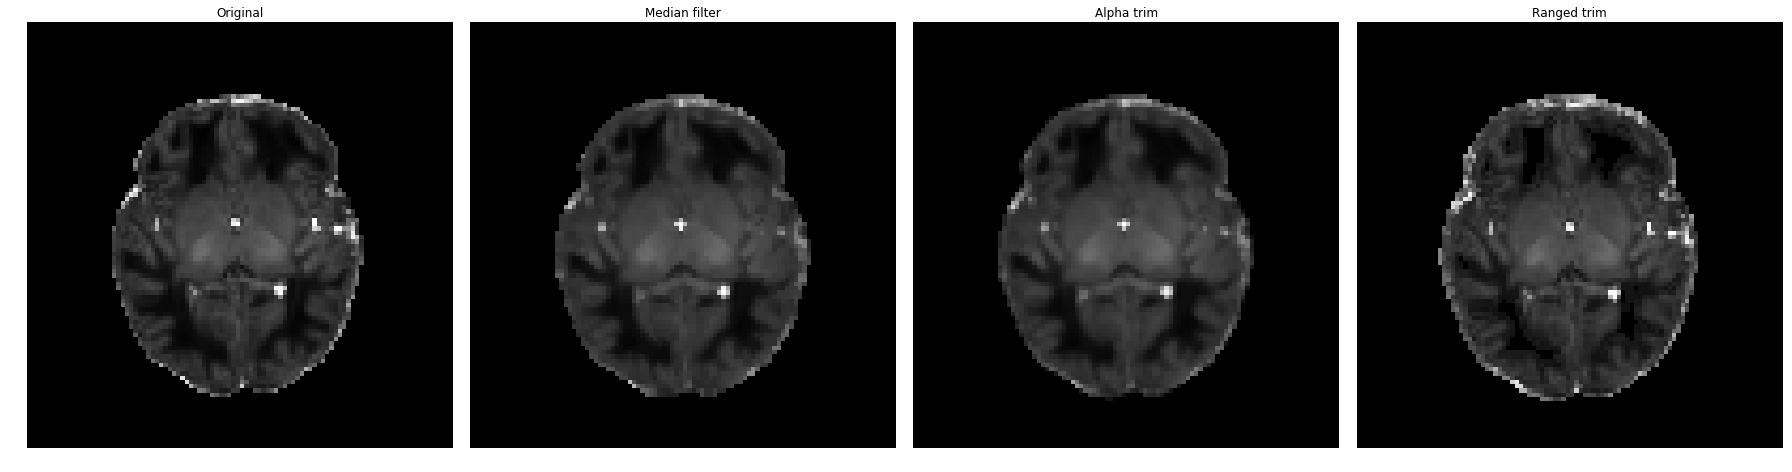

In [129]:
# display results
slc=28

denoised_median = median_filter(im, size=2 )

denoised_alpha = generic_filter(im, alpha_trim, size=2)
denoised_alpha[ np.isnan(denoised_alpha)] = 0

### get range
his, bin_edges = np.histogram(im.ravel(), bins=np.arange(0.01,1.01,0.01))
peaks, _ = find_peaks(his*-1, distance=25)
first_peak = round(bin_edges[peaks[0]],3)

denoised_2 = generic_filter(im, alpha_trim_only_outside_range, size=2, extra_arguments=(first_peak,))
denoised_2[ np.isnan(denoised_2)] = 0

fig, axes = plt.subplots(1, 4, figsize=(25, 9), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(im[slc,:,:], cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(denoised_median[slc,:,:], cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Median filter')


ax[2].imshow(denoised_alpha[slc,:,:], cmap=plt.cm.gray)
ax[2].axis('off')
ax[2].set_title('Alpha trim')

ax[3].imshow(denoised_2[slc,:,:], cmap=plt.cm.gray)
ax[3].axis('off')
ax[3].set_title('Ranged trim')



fig.tight_layout()

plt.show()

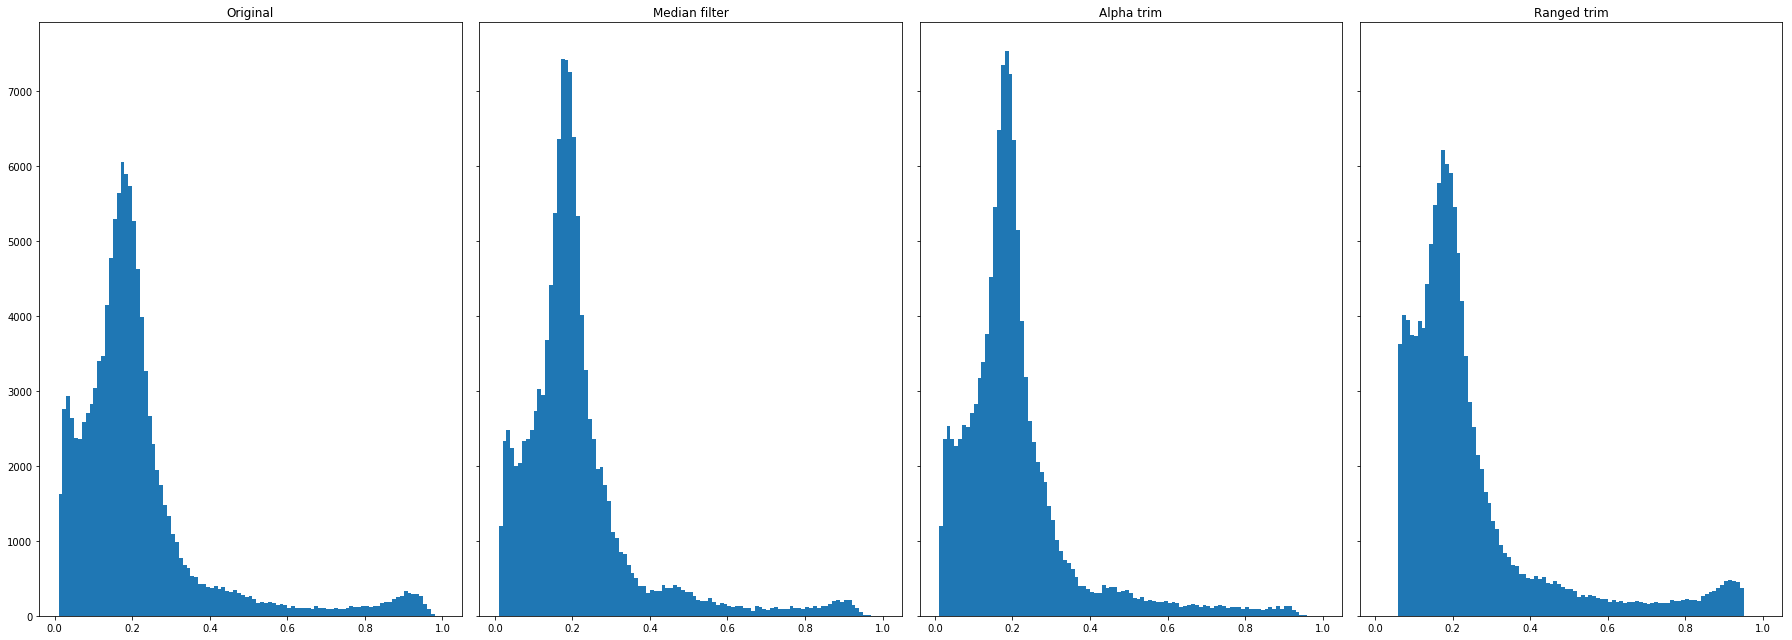

In [130]:
fig, axes = plt.subplots(1, 4, figsize=(25, 9), sharex=True, sharey=True)
bins=np.arange(0.01,1.01,0.01)
ax = axes.ravel()
ax[0].hist(im.ravel(), bins=bins)
#ax[0].axis('off')
ax[0].set_title('Original')

ax[1].hist(denoised_median.ravel(), bins=bins)
#ax[1].axis('off')
ax[1].set_title('Median filter')


ax[2].hist(denoised_alpha.ravel(), bins=bins)
#ax[2].axis('off')
ax[2].set_title('Alpha trim')

ax[3].hist(denoised_2.ravel(), bins=bins)
#ax[3].axis('off')
ax[3].set_title('Ranged trim')



fig.tight_layout()

plt.show()